# Code Snippets

__Description & purpose__: This Notebook is designed to showcase different tools and functions that are of scientific interest/use and implement the Earth Observation Data Hub. It provides a snapshot of the Hub, the `pyeodh` API client and the various datasets as of November 2024.   It is assumed that this notebook will be run within the Notebook Service on the Hub.

# Create data cube using sentinel2_ard STAC records

Users may have a need to generate a data cube directly from the CEDA Sentinel 2 Analysis Ready Data (ARD) (`sentinel2_ard`). As the STAC catalogue for that dataset has been created in a specific way, users will need to be aware of this and make alterations from the default. The following code was supplied by Pete Gadomski of Development Seed and enables the generation of a data cube from the ARD catalogue (as structured in November 2024). The STAC catalogue may be reprocessed in future to allow the default settings for `odc-stac` to be implemented.  

In [ ]:
# Note that this uses pystac and pystac_client

import os

import dask.distributed
import odc.stac
import rasterio
from pystac.extensions.raster import RasterBand
from pystac_client import Client

In [2]:
client = dask.distributed.Client()

In [3]:
client = Client.open("https://api.stac.ceda.ac.uk/")
item_collection = client.search(
    collections=["sentinel2_ard"],
    intersects={"type": "Point", "coordinates": [-1.3144, 51.5755]},
    sortby="-properties.datetime",
    max_items=10,
).item_collection()

# Commented out for clarity when submitted to training materials website.
# Uncomment the next line to view the Feature Collection

#item_collection

As of November 2024, the STAC items in `sentinel2_ard` are missing information because the projection and raster extensions are not installed. This means that `odc-stac` will refuse to compute the "geobox" and hence the subsequent components needed to generate and view the data cube. The code in the following cell adds those extensions.

In [ ]:
for item in item_collection.items:
    asset = item.assets["cog"]
    cog = rasterio.open(asset.href)
    epsg = cog.crs.to_epsg()
    dtypes = cog.dtypes
    shape = cog.shape
    transform = list(cog.transform)

    item.ext.add("proj")
    item.ext.add("raster")

    item.ext.proj.epsg = epsg

    cog = item.assets["cog"]
    cog.ext.raster.bands = [RasterBand.create(data_type=dtype) for dtype in dtypes]
    cog.ext.proj.shape = shape
    cog.ext.proj.transform = transform


In [8]:
bbox = [-1.2, 51.6, -1.1, 51.7]
dataset = odc.stac.load(item_collection, bands=("B03", "B04", "B08"), chunks={}, bbox=bbox)
dataset

<xarray.Dataset> Size: 48MB
Dimensions:      (y: 1121, x: 706, time: 10)
Coordinates:
  * y            (y) float64 9kB 2.005e+05 2.005e+05 ... 1.893e+05 1.893e+05
  * x            (x) float64 6kB 4.554e+05 4.554e+05 ... 4.624e+05 4.624e+05
    spatial_ref  int32 4B 27700
  * time         (time) datetime64[ns] 80B 2023-10-03T11:08:09 ... 2023-11-20...
Data variables:
    B03          (time, y, x) uint16 16MB dask.array<chunksize=(1, 1121, 706), meta=np.ndarray>
    B04          (time, y, x) uint16 16MB dask.array<chunksize=(1, 1121, 706), meta=np.ndarray>
    B08          (time, y, x) uint16 16MB dask.array<chunksize=(1, 1121, 706), meta=np.ndarray>

In [10]:
dataset.odc.geobox
dataset = dataset.compute()

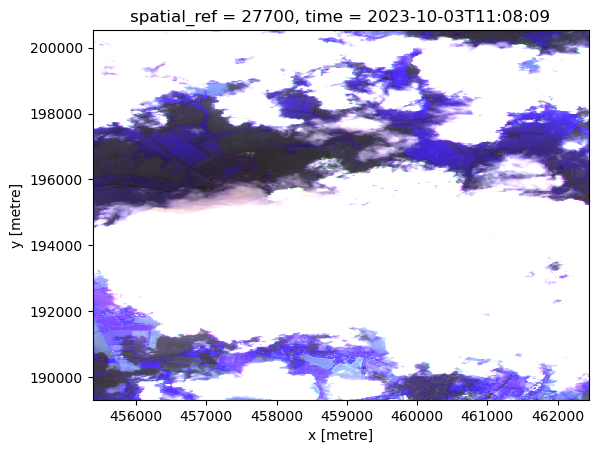

In [11]:
_ = dataset.isel(time=0).to_array("band").plot.imshow(vmin=0, vmax=256)